In [19]:
!pip install transformers datasets

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
data = '/content/gdrive/MyDrive/persian_dates_dataset.csv'

In [22]:
import pandas as pd
df = pd.read_csv(data)
df

,Informal,Formal
0,30 آبان ماه 1303,1303/08/30
1,بیست‌ و یک مهر سال 1444,1444/07/21
2,8 بهمن ماه 1374,1374/11/08
3,1418.9.30,1418/09/30
4,17 خرداد 1406,1406/03/17
...,...,...
9995,25 شهریور ماه 1346,1346/06/25
9996,12 اسفند سال 1343,1343/12/12
9997,21 فروردین ماه 1404,1404/01/21
9998,27 تیر ماه 1382,1382/04/27


In [23]:
# import necessary libs
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from datasets import Dataset
import os

In [24]:
# Add a "task prompt" column for T5
df['input_text'] = "normalize date: " + df['Informal']
df['target_text'] = df['Formal']

df.head()

,Informal,Formal,input_text,target_text
0,30 آبان ماه 1303,1303/08/30,normalize date: 30 آبان ماه 1303,1303/08/30
1,بیست‌ و یک مهر سال 1444,1444/07/21,normalize date: بیست‌ و یک مهر سال 1444,1444/07/21
2,8 بهمن ماه 1374,1374/11/08,normalize date: 8 بهمن ماه 1374,1374/11/08
3,1418.9.30,1418/09/30,normalize date: 1418.9.30,1418/09/30
4,17 خرداد 1406,1406/03/17,normalize date: 17 خرداد 1406,1406/03/17


In [25]:
# Split the data
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

In [26]:
# Using PartT5
model_name = "Ahmad/parsT5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = T5ForConditionalGeneration.from_pretrained(model_name)

In [27]:
#Tokenization function
#Final Model
def tokenize_function(examples):
    inputs = tokenizer(examples["input_text"], max_length=40, padding="max_length", truncation=True)
    targets = tokenizer(examples["target_text"], max_length=20, padding="max_length", truncation=True)

    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": targets["input_ids"]
    }

In [28]:
# Converting the data into a format suitable for model training
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, remove_columns=["Informal", "Formal", "input_text", "target_text"])
test_dataset = test_dataset.map(tokenize_function, remove_columns=["Informal", "Formal", "input_text", "target_text"])

Map:   0%|          | 0/8500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

In [29]:
os.environ["WANDB_DISABLED"] = "true" # disable Weights and Biases (WandB) logging during training

training_args = TrainingArguments(
    output_dir="./parsT5_date_normalizer",  # Directory to save model checkpoints
    evaluation_strategy="epoch",            # Evaluate at the end of each epoch
    learning_rate=2e-5,                     # Set learning rate
    per_device_train_batch_size=16,         # Batch size for training on each device
    per_device_eval_batch_size=16,          # Batch size for eval on each device
    num_train_epochs=10,                    # Number of epochs
    save_steps=500,                         # Save a checkpoint every 500 steps
    save_total_limit=2,                     # Keep only the last 2 saved checkpoints
    logging_dir="./logs",                   # Directory to store logs
    logging_steps=100,                      # Log every 100 steps
    report_to="none"                        # Disable any report logging
)

trainer = Trainer(
    model=model,                            # The model to be trained
    args=training_args,                     # Training arguments defined above
    train_dataset=train_dataset,            # Training dataset
    eval_dataset=test_dataset               # Eval dataset
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [30]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,3.555300,3.480911
2,3.427900,3.372810
3,3.387900,3.330632
4,3.355600,3.286188
5,3.335200,3.255986
6,3.306100,3.215988
7,3.273800,3.190811
8,3.252300,3.165363
9,3.244100,3.149339
10,3.235200,3.146780


TrainOutput(global_step=5320, training_loss=3.398944927875261, metrics={'train_runtime': 2038.647, 'train_samples_per_second': 41.694, 'train_steps_per_second': 2.61, 'total_flos': 4546825113600000.0, 'train_loss': 3.398944927875261, 'epoch': 10.0})

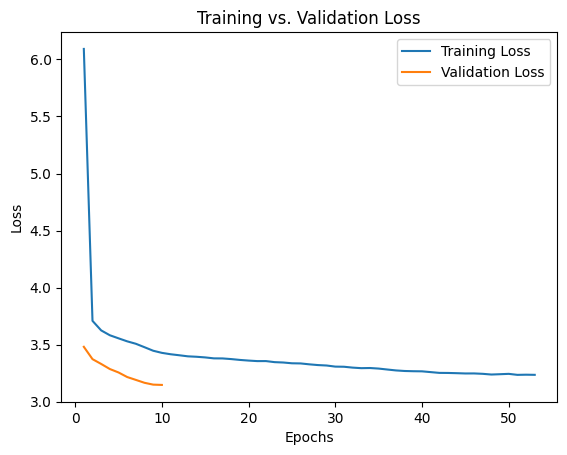

In [36]:
import matplotlib.pyplot as plt

training_loss = []
validation_loss = []

for log in trainer.state.log_history:
    if "loss" in log:
        training_loss.append(log["loss"])
    if "eval_loss" in log:
        validation_loss.append(log["eval_loss"])

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, label="Training Loss")
plt.plot(range(1, len(validation_loss) + 1), validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()

In [33]:
import random
import csv

persian_months = [
    "فروردین", "اردیبهشت", "خرداد", "تیر", "مرداد", "شهریور",
    "مهر", "آبان", "آذر", "دی", "بهمن", "اسفند"
]

def convert_to_persian_text(number):
    words = {
        1: "یک", 2: "دو", 3: "سه", 4: "چهار", 5: "پنج",
        6: "شش", 7: "هفت", 8: "هشت", 9: "نه", 10: "ده",
        11: "یازده", 12: "دوازده", 13: "سیزده", 14: "چهارده",
        15: "پانزده", 16: "شانزده", 17: "هفده", 18: "هجده",
        19: "نوزده", 20: "بیست", 21: "بیست‌ و یک", 22: "بیست ‌و دو",
        23: "بیست‌ و سه", 24: "بیست‌ و چهار", 25: "بیست‌ و پنج",
        26: "بیست ‌و شش", 27: "بیست‌ و هفت", 28: "بیست‌ و هشت",
        29: "بیست‌ و نه", 30: "سی", 31: "سی‌ و یک"
    }
    return words.get(number, str(number))

def generate_informal_date(day, month, year):
    formats = [
        f"{day} {month} {year}",  # Numeric day, month, year
        f"{convert_to_persian_text(day)} {month} {year}",  # Persian text day
        f"{convert_to_persian_text(day)} {month} سال {year}",  # With "سال"
        f"{day} {month} سال {year}",  # Numeric day + "سال"
        f"{day} {month} ماه {year}",  # Month + " ماه" (with space)
        f"{convert_to_persian_text(day)} {month} ماه {year}",  # Persian text day + " ماه" (with space)
        f"روز {convert_to_persian_text(day)} {month} {year}",  # With "روز"
        f"روز {convert_to_persian_text(day)} {month} ماه {year}",  # With "روز" + " ماه" (with space)
        f"{year}.{persian_months.index(month) + 1}.{day:02d}",  # YYYY.MM.DD
    ]
    return random.choice(formats)

In [34]:
import random
test_examples = []
for _ in range(50):
    year = random.randint(1300, 1450)
    month = random.choice(persian_months)
    day = random.randint(1, 31)

    if month in ["فروردین", "اردیبهشت", "خرداد", "تیر", "مرداد", "شهریور", "آبان", "آذر", "دی", "بهمن"] and day > 30:
        day = 30
    elif month == "اسفند" and day > 29:
        day = 29

    informal_date = generate_informal_date(day, month, year)
    test_examples.append(f"normalize date: {informal_date}")

# Print generated test examples
print("Generated Test Examples:")
for example in test_examples:
    print(example)


Generated Test Examples:
normalize date: 24 فروردین ماه 1328
normalize date: پنج تیر 1362
normalize date: روز نوزده اردیبهشت 1439
normalize date: 3 فروردین سال 1308
normalize date: 20 آذر 1359
normalize date: 1443.4.23
normalize date: 15 تیر ماه 1407
normalize date: روز بیست‌ و سه خرداد 1301
normalize date: 5 مرداد سال 1387
normalize date: روز سه اردیبهشت 1386
normalize date: بیست‌ و هشت شهریور ماه 1324
normalize date: روز بیست‌ و چهار فروردین ماه 1367
normalize date: روز سی اردیبهشت 1437
normalize date: ده آذر ماه 1320
normalize date: بیست‌ و سه تیر 1447
normalize date: 8 بهمن ماه 1311
normalize date: بیست‌ و هشت تیر 1320
normalize date: پانزده مرداد ماه 1397
normalize date: 12 شهریور سال 1341
normalize date: بیست‌ و نه اسفند 1368
normalize date: 24 آذر سال 1343
normalize date: 13 آبان ماه 1341
normalize date: بیست ‌و دو تیر ماه 1442
normalize date: 27 تیر 1314
normalize date: نه مهر 1380
normalize date: بیست‌ و نه دی ماه 1354
normalize date: روز شانزده بهمن 1354
normalize date: نه خر

In [35]:
from transformers import pipeline

normalizer = pipeline("text2text-generation", model=model, tokenizer=tokenizer)

for example in test_examples:
    result = normalizer(example, max_length=30, num_beams=4)
    print(f"Input: {example}\nOutput: {result[0]['generated_text']}")


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Input: normalize date: 24 فروردین ماه 1328
Output: 1328/01/24
Input: normalize date: پنج تیر 1362
Output: 1362/04/05
Input: normalize date: روز نوزده اردیبهشت 1439
Output: 1439/02/19
Input: normalize date: 3 فروردین سال 1308
Output: 1308/01/03
Input: normalize date: 20 آذر 1359
Output: 1359/09/20
Input: normalize date: 1443.4.23
Output: 1443/04/23
Input: normalize date: 15 تیر ماه 1407
Output: 1407/04/15
Input: normalize date: روز بیست‌ و سه خرداد 1301
Output: 1301/03/23
Input: normalize date: 5 مرداد سال 1387
Output: 1387/05/05
Input: normalize date: روز سه اردیبهشت 1386
Output: 1386/02/03
Input: normalize date: بیست‌ و هشت شهریور ماه 1324
Output: 1324/06/28
Input: normalize date: روز بیست‌ و چهار فروردین ماه 1367
Output: 1367/01/24
Input: normalize date: روز سی اردیبهشت 1437
Output: 1437/02/30
Input: normalize date: ده آذر ماه 1320
Output: 1320/09/10
Input: normalize date: بیست‌ و سه تیر 1447
Output: 1447/04/23
Input: normalize date: 8 بهمن ماه 1311
Output: 1311/11/08
Input: normaliz